<a href="https://colab.research.google.com/github/timou0911/CryptoClash/blob/main/Homework_Credit_Risk_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem:


# **Credit Risk Assessment using Random Forest or Xgboost**



Objective:

- Build Random Forest model using the sklearn library.
- Apply model to a real-world problem (credit scoring).
- Use appropriate metrics to evaluate the model's performance.  

Context:

- In the financial sector, credit scoring is a common and important problem. Banks need to determine whether to grant a loan to an individual based on their credit score, which reflects the borrower's ability to repay. Generally, this is a binary classification problem (good/bad score).
- A common issue in this problem is the imbalance of classes: the number of bad credits is usually much smaller than the number of good credits ==> resulting in imbalanced class labels.

Data:

- Provided in tabular form, where each row represents a borrower and each column represents an attribute of that borrower.
- Attributes can be categorical, numeric (discrete/continuous), and field names might be anonymized or encrypted for customer privacy.
- Two datasets will be used: [German credit](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) and [Australian credit.](https://archive.ics.uci.edu/ml/datasets/Statlog+(Australian+Credit+Approval)


Problem Modeling: Binary classification problem

- Input: $N$ vectors of $D$ dimensions (a matrix of size $N \times D$), corresponding to $N$ individuals with $D$ attributes.
- Output: labels $0-1$ (0: bad credit, 1: good credit).

### 1. Data Preprocessing for training

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

random_state = 42
%pwd

'/content'

In [12]:
df = pd.read_csv("./german_credit_data_encoded.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,1,1,2,0,1169,6,5,1
1,22,0,1,1,0,1,5951,48,5,0
2,49,1,3,1,0,2,2096,12,3,1
3,45,1,1,0,0,0,7882,42,4,1
4,53,1,1,0,0,0,4870,24,1,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Age               1000 non-null   int64
 1   Sex               1000 non-null   int64
 2   Job               1000 non-null   int64
 3   Housing           1000 non-null   int64
 4   Saving accounts   1000 non-null   int64
 5   Checking account  1000 non-null   int64
 6   Credit amount     1000 non-null   int64
 7   Duration          1000 non-null   int64
 8   Purpose           1000 non-null   int64
 9   Risk              1000 non-null   int64
dtypes: int64(10)
memory usage: 85.9 KB


In [14]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [15]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column and encode categorical variables
for column in df.columns:
    if df[column].dtype == 'object':  # Encode only categorical variables
        df[column] = label_encoder.fit_transform(df[column].astype(str))

# Display the encoded DataFrame
df.to_csv("./german_credit_data_encoded.csv")

In [16]:
X = df.drop("Risk", axis=1)
y = df["Risk"]

In [17]:
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1000, 9) (1000,)
(800, 9) (200, 9)


### 2. Training

#### 2.1. Initialize the Random Forest models from Sklearn

In [18]:
clf = RandomForestClassifier(random_state=random_state)

##### 2.2. Run the baseline Decision Tree or Xgboost

In [19]:
print('-- Baseline Random Forest Prediction --')
clf.fit(X_train, y_train)
y_baseline_pred = clf.predict(X_test)
print("Accuracy = {}".format(accuracy_score(y_test, y_baseline_pred)))
print("F1 score = {}".format(f1_score(y_test, y_baseline_pred)))
print("ROC AUC = {}".format(roc_auc_score(y_test, y_baseline_pred)))
print(confusion_matrix(y_test, y_baseline_pred))

-- Baseline Random Forest Prediction --
Accuracy = 0.775
F1 score = 0.8504983388704319
ROC AUC = 0.682714268541892
[[ 27  32]
 [ 13 128]]


### 3. Fine-tune hyperparameters

In [20]:
# Some supporting functions
def grid_search(algorithm, n_jobs, dict_param):
    if algorithm == 'decision-tree':
        model = DecisionTreeClassifier()
    if algorithm == 'random-forest':
        model = RandomForestClassifier()
    classifier = GridSearchCV(estimator=model, cv=5, param_grid=dict_param,
                            n_jobs=n_jobs, scoring='f1')
    classifier.fit(X_train, y_train)
    print('Best model', end='')
    print(classifier.best_estimator_)
    return classifier.best_estimator_

def evaluate(model):
    print("Train Accuracy :", accuracy_score(y_train, model.predict(X_train)))
    print("Train f1 score :", f1_score(y_train, model.predict(X_train)))
    print("Train roc auc :", roc_auc_score(y_train, model.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, model.predict(X_test)))
    print("Test f1 score :", f1_score(y_test, model.predict(X_test)))
    print("Test roc auc :", roc_auc_score(y_test, model.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(X_test)))

def plot_learning_curve(estimator, title, label_curve, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), new_plot=False,
                        idx_color=0):
    # Initialize a new image using the plot lib library.
    if new_plot:
        # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()
    # Add a caption if available.
    if ylim is not None:
        plt.ylim(*ylim)

    # Perform model training, record values during the training process
    # cv = number of cross-validation folds, the number of data splits used for training and testing
    # train_sizes = array of ratios, the ratios at which the system selects as stopping points to perform testing
    # train_sizes = [0.3, 0.5] => the system uses 30% of the data for training and testing, similarly for 50% ..
    # scoring = objective function to evaluate model quality and plot on the graph

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1")
    # Calculate the average of output values across folds
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot numerical values on a graph with randomly selected colors
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label=label_curve['test'])
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
             label=label_curve['train'])

    plt.legend(loc="best")
    return plt

##### 3.1. Fine-tune hyperparameters with model Decision Tree

Text(0.5, 1.0, 'Random Forest validation curve for max_depth')

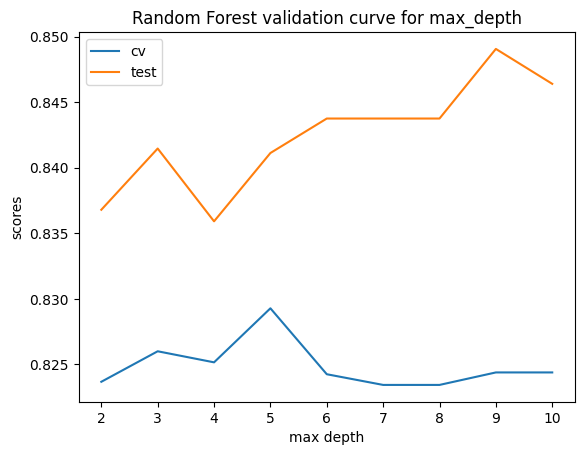

In [21]:
cv_accuracies_by_depth, test_accuracies_by_depth= [], []
max_depth_values= np.arange(2,11)

for curr_max_depth in max_depth_values:
  tree = RandomForestClassifier(random_state=random_state, max_depth=curr_max_depth, min_samples_leaf=20)

  # cross-validation
  val_scores= cross_val_score(estimator=tree, X=X_train, y=y_train, cv=5, scoring='f1')
  cv_accuracies_by_depth.append(val_scores.mean())

  # test
  tree.fit(X_train, y_train)
  curr_pred= tree.predict(X_test)
  test_accuracies_by_depth.append(f1_score(curr_pred, y_test))

# Plot
plt.plot(max_depth_values, cv_accuracies_by_depth, label='cv')
plt.plot(max_depth_values, test_accuracies_by_depth, label='test')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('scores')
plt.title('Random Forest validation curve for max_depth')

In [22]:
# Try using GridSearchCV to explore.
dict_param = {
    'max_depth': [2, 3, 5, 7, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
best_tree = grid_search('random-forest', n_jobs=-1, dict_param=dict_param)


Best modelRandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5)


### 4. Evaluate best_tree
- Prediction performance
- Learning curve

Train Accuracy : 0.8175
Train f1 score : 0.8807189542483659
Train roc auc : 0.7207001239617277
Train Confusion Matrix:
[[115 126]
 [ 20 539]]
--------------------------------------------------
Test Accuracy : 0.735
Test f1 score : 0.8306709265175719
Test roc auc : 0.6050607044115879
Test Confusion Matrix:
[[ 17  42]
 [ 11 130]]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

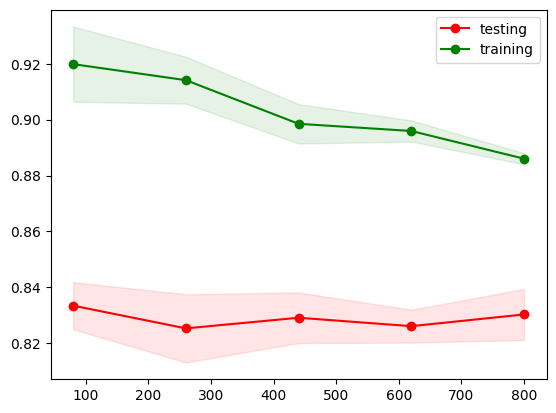

In [23]:
### Your code here
evaluate(best_tree)
label = {
  'train':  'training' ,
  'test': 'testing'
}
plot_learning_curve(best_tree, title="Evaluation Best tree", label_curve=label , X=X, y=y )

### 5. Experiment with additional additions.



> You can research and apply [SHAP](https://shap.readthedocs.io/en/latest/)  to important feature information



##### 5.1. Show feature importance

Feature importances
Feature  5 - 0.24615960236131693
Feature  6 - 0.2111750320378591
Feature  0 - 0.15695593580868805
Feature  7 - 0.1426634002330581
Feature  8 - 0.07401479811301115
Feature  4 - 0.07391179657299221
Feature  2 - 0.034373544358352597
Feature  3 - 0.03330467551421866
Feature  1 - 0.027441215000503238


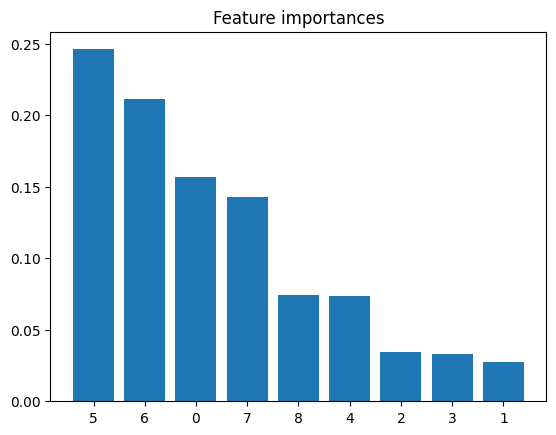

In [24]:
### Your code here
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]
print('Feature importances')
for i in range(9):
    print('Feature ', indices[i] , '-', importances[indices[i]])

indices = indices[:10]
plt.figure()
plt.title('Feature importances')
plt.bar(range(9), importances[indices])
plt.xticks(range(9), indices)
plt.show()

#### 5.2. Remove some features with low importance.

In [38]:
### Your code here
# X_train_new = X_train.drop([X.columns[1], X.columns[3]] , axis=1)
# X_test_new = X_test.drop([X.columns[1], X.columns[3]] , axis=1)
X_train_new = X_train.drop([X.columns[1]] , axis=1)
X_test_new = X_test.drop([X.columns[1]] , axis=1)
X_test_new

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
521,24,1,1,0,0,3190,18,5
737,35,3,1,1,0,4380,18,1
740,32,1,1,1,0,2325,24,1
660,23,1,2,0,3,1297,12,5
411,35,0,1,0,2,7253,33,1
...,...,...,...,...,...,...,...,...
408,26,0,1,3,2,3235,24,5
332,24,0,1,1,1,7408,60,1
208,21,3,1,0,0,6568,24,0
613,22,1,2,0,0,3632,24,1


In [50]:
### Your code here
best_param = {
    'max_depth': 10,
    'min_samples_leaf': 5,
    'criterion': "entropy"
}

best_tree = DecisionTreeClassifier(random_state=random_state, **best_param)

print('-- Baseline Random Forest Prediction --')
clf.fit(X_train, y_train)
y_baseline_pred = clf.predict(X_test)
print("Accuracy = {}".format(accuracy_score(y_test, y_baseline_pred)))
print("F1 score = {}".format(f1_score(y_test, y_baseline_pred)))
print("ROC AUC = {}".format(roc_auc_score(y_test, y_baseline_pred)))
print(confusion_matrix(y_test, y_baseline_pred))
print('-- Improved Random Forest Prediction --')
best_tree.fit(X_train_new, y_train)
y_pred = best_tree.predict(X_test_new)
print("-DT acc = {}".format(accuracy_score(y_test, y_pred)))
print("-DT f1 = {}".format(f1_score(y_test, y_pred)))
print("-DT roc auc = {}".format(roc_auc_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

-- Baseline Random Forest Prediction --
Accuracy = 0.775
F1 score = 0.8504983388704319
ROC AUC = 0.682714268541892
[[ 27  32]
 [ 13 128]]
-- Improved Random Forest Prediction --
-DT acc = 0.735
-DT f1 = 0.8086642599277979
-DT roc auc = 0.6937732900589013
[[ 35  24]
 [ 29 112]]


In [ ]:
### Your code here